In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import operator
import random
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
import itertools

%matplotlib inline 

## Graph Creation

Create a graph named facebook from the Facebook data in file facebook-links.txt. As noted, we use the Graph class.

In [2]:
facebook = nx.Graph()

## Read dataset, Draw the Graph

File facebook-links.txt contains a list of all of the user-to-user links from the Facebook New Orleans networks. 
These links are undirected on Facebook.

Format: Each line contains two numeric user identifiers, 
meaning the second user appeared in the first user's friend list, 
and the first user appeared in the second user's friend list. 
Finally, the third column is a UNIX timestamp with the time of link establishment 
(if it could be determined, otherwise it is unavailable).

In [3]:
def open_source_file(filename):
    with open (filename,"r") as file:
        if filename == "../data/facebook-links.txt":
            content = file.readlines()
            for i in range(len(content)):
                point1 = content[i].split("\t")[0]
                if point1 not in facebook:
                    facebook.add_node(point1)
                point2 = content[i].split("\t")[1]
                if point2 not in facebook:
                    facebook.add_node(point2)
                facebook.add_edge(point1,point2)
        elif filename == "../data/facebook-links.txt":
            result = [x.strip("\n") for x in file.readlines()]
            for i in range(len(result)):
                point1 = result[i].split(" ")[0]
                if point1 not in facebook:
                    facebook.add_node(point1)
                point2 = result[i].split(" ")[1]
                if point2 not in facebook:
                    facebook.add_node(point2)
                facebook.add_edge(point1,point2)
        else:
            print ("Not a valid file, please check again")

In [4]:
open_source_file("../data/facebook-links.txt")

Print only first 10 edges of facebook graph

In [5]:
fbnodes = facebook.nodes()
print (fbnodes[: 10])

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


Print only first 10 edges of facebook graph

In [6]:
fbedges = facebook.edges()
print(fbedges[: 10])

[('1', '2'), ('1', '3'), ('1', '4'), ('1', '5'), ('1', '6'), ('1', '7'), ('1', '8'), ('1', '9'), ('1', '10'), ('1', '11')]


In [7]:
def show_basic_info(graph):
    print (nx.info(graph))

In [8]:
print ("Original Dataset")
show_basic_info(facebook)

Original Dataset
Name: 
Type: Graph
Number of nodes: 63731
Number of edges: 817090
Average degree:  25.6418


# Data Cleaning 

## Remove the user only have one friend

We noticed that in the facebook graph, there are around 8000 nodes that only have one edges, which means they only have one friend in the whole network connection. It is possible that they are fake users/people don't use facebook too often. Furthermore, they bring some trouble if we want to manually remove some friends connections in the evaluation part. So we removed those nodes as well as their edges for the ease of future evaluation.

In [9]:
# only do it once!!!!
def remove_user_with_one_friend(graph):
    edge_to_remove = {}
    # find the user with only one friend, and store the edge connection as a dictionary format.
    # the format of dictionary is: {user(shown in user_id): the only friend(shown in user_id)}
    for node in nx.nodes_iter(graph):
        if (len(graph.neighbors(node)) <= 1):
            neighbor = graph.neighbors(node)
            edge_to_remove[node] = neighbor[0]
        else:
            pass
    
    first10pairs = {k: edge_to_remove[k] for k in list(edge_to_remove)[:10]}
    print ("First 10 pairs",first10pairs)
        
    for key in edge_to_remove:
        if graph.has_edge(key,edge_to_remove[key]):
            graph.remove_edge(key,edge_to_remove[key])
        else:
            pass
        if graph.has_node(key):
            graph.remove_node(key)
        else:
            pass
    # after removing,there are some nodes that don't have edges.We simply delete those nodes as well. 
    further_node_to_remove = []
    for node in nx.nodes_iter(graph):
        if (len(graph.neighbors(node)) == 0):
            further_node_to_remove.append(node)
    print ("After preliminary removing, further remove users with no friends",further_node_to_remove)
    for node in further_node_to_remove:
        graph.remove_node(node)

In [10]:
remove_user_with_one_friend(facebook)

First 10 pairs {'59': '58', '557': '555', '763': '758', '848': '559', '983': '968', '1117': '1118', '1270': '1271', '1355': '1036', '2089': '1409', '2100': '1999'}
After preliminary removing, further remove users with no friends ['47051', '47622', '48982', '49268', '52667', '53950', '54139', '54883', '54960', '55357', '55408', '55521', '55687', '56246', '59296', '59884', '59925', '60945', '61214', '61446', '62354']


In [11]:
print ("Dataset after removing")
show_basic_info(facebook)

Dataset after removing
Name: 
Type: Graph
Number of nodes: 55612
Number of edges: 809100
Average degree:  29.0980


# Exploratory data analysis

## basic information

Transform the dataset into an adjacency matrix, shown as the dictionary format. The key is the user,shown as user_id, and corresponding values are friends, shown as user_id as well. The format is {key user_id : friend_id 1....}

In [12]:
adjacency_matrix = {}
for node in nx.nodes_iter(facebook):
    adjacency_matrix[int(node)] = [neighbor for neighbor in nx.all_neighbors(facebook,node)]   
# print the first 10 users with their friends for testing purposes
for i in range(5):
    print ("adjacency_matrix",[i+1],":",adjacency_matrix[i+1])

adjacency_matrix [1] : ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27']
adjacency_matrix [2] : ['1', '1132', '3', '2053', '2054', '479', '51', '2055', '7', '9', '1645', '11', '12', '2056', '16', '17', '18', '2057', '1237', '23', '2058', '53', '2059', '2060', '1079', '2061']
adjacency_matrix [3] : ['1', '1747', '2', '2599', '1638', '1199', '2600', '683', '1289', '2055', '6', '7', '2958', '1645', '11', '12', '2056', '1649', '309', '15', '16', '17', '18', '19', '30605', '1003', '17297', '15818', '1237', '42296', '821', '53', '4223', '2059']
adjacency_matrix [4] : ['1', '2636', '2638', '2174', '2957', '2958', '2175', '2959', '2960']
adjacency_matrix [5] : ['1', '813', '1636', '814', '1640', '4503', '1641', '1642', '683', '2054', '4964', '1643', '1644', '639', '2957', '4219', '2056', '687', '815', '1646', '1648', '1649', '1650', '4246', '22', '1095', '12366', '821', '469', '2548', '27', '1236

Construct a new dictionary, return for each user that how many friends they have in total. The key is the user,shown as user_id, and corresponding values are number of friends, shown as user_id as well. The format is {key user_id : number of friends}. And then, sort by the number of friends in descending order.

In [13]:
num_of_friends = {}
for key in adjacency_matrix:
    num_of_friends[int(key)] = len(adjacency_matrix[key])

Print the 10 users with most friends, with their ID and number of friends, in descending order.

In [14]:
updat_num_of_friends = sorted(num_of_friends.items(), key=lambda x: (-x[1], x[0]))
friends_num = pd.DataFrame(data=updat_num_of_friends)
friends_num.columns = ['user_id','num_of_friends']
friends_num.head(n = 10)

,user_id,num_of_friends
0,2332,1095
1,471,932
2,554,915
3,2322,797
4,451,766
5,23,763
6,2208,737
7,9904,722
8,1463,620
9,3943,619


Print the 10 users with least friends, with their ID and number of friennds. Since they have the same number of friends, we will disaply in the order of user_id, in ascending order. 

In [15]:
friends_num.tail(n = 10)

,user_id,num_of_friends
55602,63389,1
55603,63399,1
55604,63433,1
55605,63473,1
55606,63489,1
55607,63504,1
55608,63538,1
55609,63601,1
55610,63616,1
55611,63638,1


Get stats on number of friends per user

In [16]:
friends_num['num_of_friends'].describe()

count    55612.000000
mean        29.098036
std         41.595270
min          1.000000
25%          5.000000
50%         14.000000
75%         37.000000
max       1095.000000
Name: num_of_friends, dtype: float64

# Graph plot

['7848', '33203', '9155', '30370', '38586', '47870']
[['4578', '7820', '7823', '7825', '7826', '7827', '7828', '9566', '7831', '11919'], ['17866', '23432', '26289', '38619', '16351', '45672', '13078', '38817', '23433', '21094'], ['8521', '21379', '14312', '26276', '2274', '21937', '10632', '5565', '8121', '5594'], ['8087', '11019', '12021', '4091', '15181', '24159', '26658', '26308', '15151', '26310'], ['14582', '41334', '18258', '38594', '33961', '29750', '31794', '41341', '36076', '35666'], ['1463', '19400', '63494', '21065']]


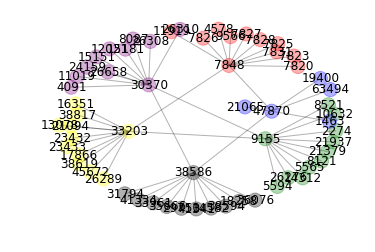

In [29]:
test_graph = nx.Graph()
node_chosen = []
node_to_collect = [[],[],[],[],[],[]]

for i in range(6):
    friend_chosen = random.choice(facebook.nodes())
    node_chosen.append(friend_chosen)
    test_graph.add_node(friend_chosen)
    all_nodes = nx.all_neighbors(facebook,friend_chosen)
    
    for node in all_nodes:
        node_to_collect[i].append(node)
    node_to_collect[i] = node_to_collect[i][: 10]
    
    for node in node_to_collect[i]:
        test_graph.add_node(node)
        test_graph.add_edge(node_chosen[i],node)
print (node_chosen)
print (node_to_collect)

for i in range(5):
    test_graph.add_edge(node_chosen[i],node_chosen[i+1])

test_graph.add_edge(node_chosen[5],node_chosen[0])
        
color_map = []
for node in nx.nodes_iter(test_graph):
    if ((node in node_chosen[0]) or (node in node_to_collect[0])):
        color_map.append("red")
    elif ((node in node_chosen[1]) or (node in node_to_collect[1])):
        color_map.append("yellow")
    elif ((node in node_chosen[2]) or (node in node_to_collect[2])):
        color_map.append("green")
    elif ((node in node_chosen[3]) or (node in node_to_collect[3])):
        color_map.append("purple")
    elif ((node in node_chosen[4]) or (node in node_to_collect[4])):
        color_map.append("black")
    else:
        color_map.append("blue")
        
nodesize = []
for node in nx.nodes_iter(test_graph):
    if node in node_chosen:
        nodesize.append("500")
    else:
        nodesize.append("50")
       
nx.draw_networkx(test_graph,node_color = color_map,node_size=200,alpha = 0.3)

limits=plt.axis('off')
plt.figure(figsize=(2000,2000))
plt.show()

In [341]:
cat_0_5 = cat_5_10 = cat_10_15 =cat_15_20 = cat_20_25 = cat_25_30 = cat_30_40 = cat_40_60 = cat_60_100 = cat_100_500 = cat_500_1000 = cat_else = 0
cat_else = 0
frequency = []
for count in friends_num.num_of_friends:
    if count >= 0 and count <= 5:
        cat_0_5 += 1
    elif count > 5 and count <= 10:
        cat_5_10 += 1
    elif count > 10 and count <= 15:
        cat_10_15 += 1
    elif count > 15 and count <= 20:
        cat_15_20 += 1  
    elif count > 20 and count <= 25:
        cat_20_25 += 1  
    elif count > 25 and count <= 30:
        cat_25_30 += 1
    elif count > 30 and count <= 40:
        cat_30_40 += 1 
    elif count > 40 and count <= 60:
        cat_40_60 += 1 
    elif count > 60 and count <= 100:
        cat_60_100 += 1
    elif count > 100 and count <= 500:
        cat_100_500 += 1
    elif count > 500 and count <= 1000:
        cat_500_1000 += 1
    else:
        cat_else += 1
        
frequency.extend([cat_0_5,cat_5_10,cat_10_15,cat_15_20,cat_20_25,cat_25_30,cat_30_40,cat_40_60,cat_60_100,cat_100_500,cat_500_1000,cat_else])

freq_dataframe = pd.DataFrame()
freq_dataframe['nummber of friends in group'] = ["0-5 friends","5-10 friends","10-15 friends","15-20 friends","20-25 friends","25-30 friends","30-40 friends","40-60 friends","60-100 friends","100-500 friends","500-1000 friends","> 1000 friends"]
freq_dataframe['number_of_users']= frequency
freq_dataframe

,nummber of friends in group,number_of_users
0,0-5 friends,15226
1,5-10 friends,8710
2,10-15 friends,5760
3,15-20 friends,3983
4,20-25 friends,3104
5,25-30 friends,2549
6,30-40 friends,3748
7,40-60 friends,4827
8,60-100 friends,4465
9,100-500 friends,3214


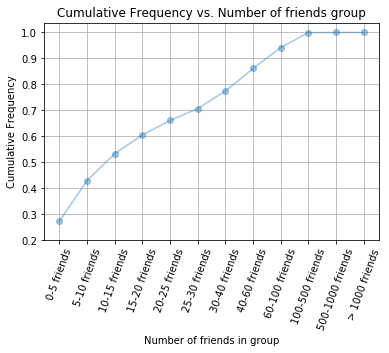

In [222]:
totcount = len(friends_num)
x = [1,2,3,4,5,6,7,8,9,10,11,12]
frequency[:] = [x / totcount for x in frequency]
opacity = 0.4
# x_labels = ["0-5 friends","5-10 friends","10-15 friends","15-20 friends","20-25 friends","25-30 friends","30-40 friends","40-60 friends","60-100 friends","100-500 friends","500-1000 friends","> 1000 friends"]
plt.plot([x+1 for x in range(len(frequency))], np.cumsum(frequency), '-o',alpha = opacity)
plt.xticks(x, x_labels, rotation=70)
plt.yticks(np.arange(0.2,1.1,0.1))
plt.title('Cumulative Frequency vs. Number of friends group')
plt.xlabel('Number of friends in group')
plt.ylabel('Cumulative Frequency')
plt.grid()
plt.show()

[15226, 8710, 5760, 3983, 3104, 2549, 3748, 4827, 4465, 3240]


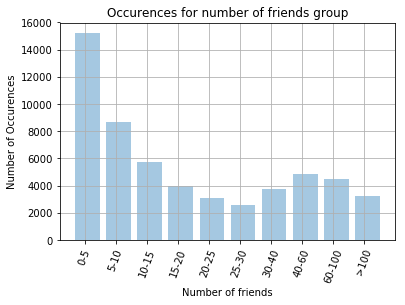

In [233]:
num_count = []
last_3 = cat_100_500 + cat_500_1000 + cat_else
num_count.extend([cat_0_5,cat_5_10,cat_10_15,cat_15_20,cat_20_25,cat_25_30,cat_30_40,cat_40_60,cat_60_100,last_3])
print (num_count)
x = [1,2,3,4,5,6,7,8,9,10]

index = np.arange(1,11,1)
bar_width = 0.2

plt.bar(x, num_count, align='center',alpha=opacity)
plt.xticks(index - bar_width / 2, ("0-5","5-10","10-15","15-20","20-25","25-30","30-40","40-60","60-100",">100"),rotation=70)
plt.xlabel("Number of friends")
plt.ylabel('Number of Occurences')
plt.title('Occurences for number of friends group')
plt.grid()
plt.show()

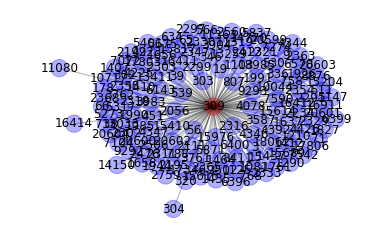

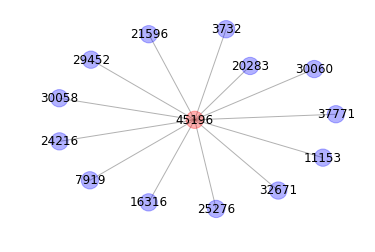

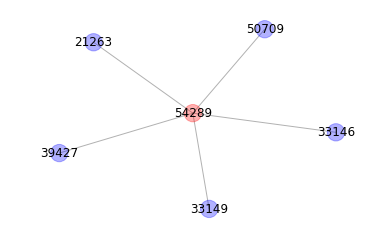

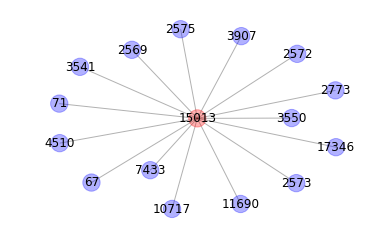

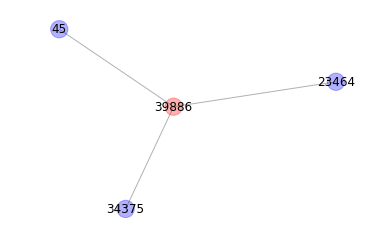

In [17]:
test_graph2 = nx.Graph()
for i in range(5):
    friend_chosen = random.choice(facebook.nodes())
    # test_graph2.add_node(friend_chosen)
    for node in nx.all_neighbors(facebook,friend_chosen):
        test_graph2.add_edge(node,friend_chosen)

    color_map = []
    for node in nx.nodes_iter(test_graph2):
        if node is friend_chosen:
            color_map.append("red")
        else:
            color_map.append("blue")
    pos = nx.spring_layout(test_graph2)
    nx.draw_networkx(test_graph2,node_color = color_map,alpha = 0.3)
    limits=plt.axis('off')
    plt.figure(figsize=(2000,2000))
    plt.show()
    
    test_graph2.clear()

## Calculate the sparisty of dataset

In [141]:
num_users = len(adjacency_matrix)

print (num_users)
utility = np.zeros((num_users, num_users))
for user_id, user_friend_ids in adjacency_matrix.items():
    for x in user_friend_ids:
        utility[(int)(user_id) - 1, (int)(x) - 1] = 1
        
sparsity = float(len(utility.nonzero()[0]))
sparsity /= (utility.shape[0] * utility.shape[1])
sparsity *= 100
print('Sparsity: {:.2f}%'.format(sparsity))

63731


MemoryError: 

# Recommend via Similar Users

## Evaluation via Mean Squared Error (MSE)

In [11]:
def mse_utility(u1, u2):
    return mse(u1[u1.nonzero()].flatten(), u2[u2.nonzero()].flatten())

# u1 = np.array([[2, 0, 0, 4, 4], [5, 5, 5, 3, 3], [2, 4, 2, 1, 2]])
# u2 = np.array([[3, 0, 0, 4, 4], [5, 5, 5, 3, 3], [2, 4, 2, 1, 7]])

# print("{:.4f}".format(mse_utility(u1, u2)))

## Similarity via Cosine Distance

In [12]:
def cosine_sim(v1, v2):
    numerator = sum([x * y for x, y in zip(v1, v2)])
    denominator = np.sqrt(sum([x ** 2 for x in v1])) * np.sqrt(sum([x ** 2 for x in v2]))
    return numerator / denominator

In [13]:
def sim_matrix(u, eps=1.0e-9):
    step1 = u.dot(u.T) + eps
    step2 = np.array([np.sqrt(np.diagonal(step1))])
    return (step1 / step2 / step2.T)

In [14]:
%timeit -n 10 -r 3 sim_matrix(utility[:50,:])

10 loops, best of 3: 12 ms per loop


In [15]:
def sim_users(u):
    return sim_matrix(u)

print(sim_users(utility[:50,:50]))

[[  1.00000000e+00   5.58156306e-01   5.91312396e-01 ...,   7.41249317e-02
    1.96116135e-10   2.77350098e-01]
 [  5.58156306e-01   1.00000000e+00   6.67423813e-01 ...,   1.19522861e-01
    3.16227766e-10   2.23606798e-01]
 [  5.91312396e-01   6.67423813e-01   1.00000000e+00 ...,   1.13960576e-10
    3.01511344e-10   2.13200717e-01]
 ..., 
 [  7.41249317e-02   1.19522861e-01   1.13960576e-10 ...,   1.00000000e+00
    3.77964473e-01   2.67261242e-10]
 [  1.96116135e-10   3.16227766e-10   3.01511344e-10 ...,   3.77964473e-01
    1.00000000e+00   7.07106781e-10]
 [  2.77350098e-01   2.23606798e-01   2.13200717e-01 ...,   2.67261242e-10
    7.07106781e-10   1.00000000e+00]]


## K-Neighborhood

In [16]:
def top_k(arr, self_idx, k):
    val_index = { v:key for key, v in enumerate(arr) }
    top_k_val = sorted(val_index.keys())[::-1]
    i = 0
    res = {}
    while i < k:
        if val_index[top_k_val[i]] == self_idx:
            i += 1
            k += 1
            continue
        res[val_index[top_k_val[i]]] = top_k_val[i]
        i += 1
    return res

## Recommend via Similar Users

In [ ]:
def rec_via_users(m_utility, m_sim_users, user_idx, frd_idx, k):
    items = m_utility[:, frd_idx]
    i_sim = top_k(m_sim_users[:, user_idx], user_idx, k)
    non_zero_index = [i for i in i_sim if items[i] != 0]
    if sum([i_sim[i] for i in non_zero_index]) == 0:
        return 0
    return sum([i_sim[i] * items[i] for i in non_zero_index]) / sum([i_sim[i] for i in non_zero_index])

## Evaluation

In [ ]:
random.seed(12345)

def recs_via_users(m_utility, m_sim_users, k, test_n):
    test = random.sample(range(m_sim_users.shape[0]), test_n)
    true = []
    pred = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                
                p = round(rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k))
                if p != 0:    
                    pred.append(p)
                else:
                    pred.append(1.0e-9)
                        

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))
    
similarity_users = sim_users(utility)

ks = []
mses = []
for i in range(50):
    ks.append(i+1)
    mses.append(recs_via_users(utility, similarity_users, i+1, 100))
    print("{}/50".format(i+1), mses[-1])

In [ ]:
friends_num = pd.DataFrame(data=updat_num_of_friends)
friends_num.columns = ['number of friends', 'user_id']
friends_num.head()

# Recommend by number of common friends

## friends set 

Returns a set of the friends of the given user, in the given graph.
The parameter 'user' is the string name of a person in the graph.

In [88]:
def friends(graph, user):
    return set(graph.neighbors(user))

## friends of friends set

Returns a set of friends of friends of the given user, in the given graph.
The result does not include the given user nor any of that user's friends.

In [89]:
def friends_of_friends(graph, user):
    f_list = set()
    friend_list = friends(graph,user)
    for friend in friend_list:
        f_list.update(set(friends(graph,friend)))
    for friend in friend_list:
        f_list.discard(friend)
    f_list.remove(user)
    return f_list

## Common friends between two users

Returns the set of friends that user1 and user2 have in common.

In [90]:
def common_friends(graph, user1, user2):
    friend_set_1 = friends(graph,user1)
    friend_set_2 = friends(graph,user2)
    return (friend_set_1 & friend_set_2)

Returns a map from each user U to the number of friends U has in common with the given user.
    The map keys are the users who have at least one friend in common with the
    given user, and are neither the given user nor one of the given user's friends.
    Take a graph G for example:
        - A and B have two friends in common
        - A and C have one friend in common
        - A and D have one friend in common
        - A and E have no friends in common
        - A is friends with D
    number_of_common_friends_map(G, "A")  =>   { 'B':2, 'C':1 }

In [91]:
def number_of_common_friends_map(graph, user):
    number_common = { str(friend) : len(common_friends(graph,str(friend),user)) for friend in friends_of_friends(graph,user) }
    return number_common

## Key list

Given a map whose values are numbers, return a list of the keys. The keys are sorted by the number they map to, from greatest to least. When two keys map to the same number, the keys are sorted by their natural sort order, from least to greatest.

In [92]:
def number_map_to_sorted_list(map):
    res = sorted(map.items(), key=lambda x: (-x[1], x[0]))
    numbers = [item[0] for item in res]
    return numbers

## Recommend  by number of common friends

Return a list of friend recommendations for the given user.The friend recommendation list consists of names of people in the graph who are not yet a friend of the given user.The order of the list is determined by the number of common friends.

In [93]:
def recommend_by_number_of_common_friends(graph, user):
    common_friends = number_of_common_friends_map(graph,user)
    return number_map_to_sorted_list(common_friends)

## Evaluation

In [114]:
# randomly pick a user, generate friend list based on the recommendataion algorithm
# compare with its actual friend list  
def eva_recommend_friends(graph):
    friend_chosen = random.choice(graph.nodes())
    print (friend_chosen)
    rec_by_num_of_common_friends = recommend_by_number_of_common_friends(graph,friend_chosen)
    real_friends = friends(graph,friend_chosen)
    print (rec_by_num_of_common_friends)
    print (real_friends)
    correct = 0
    wrong = 0
    
    for friend in real_friends:
        if friend in rec_by_num_of_common_friends:
            correct += 1
        else:
            wrong += 1
    print (correct,wrong)

In [115]:
eva_recommend_friends(facebook)

35236
['29469', '20578', '24369', '24980', '36721', '11806', '20819', '24361', '8664', '20846', '25082', '34369', '24973', '15588', '24986', '41175', '15582', '26953', '36954', '19519', '27396', '27851', '9874', '15331', '25279', '31218', '42748', '11615', '26875', '27622', '36333', '9880', '27719', '3703', '25663', '27130', '32668', '3665', '133', '15580', '25558', '27406', '31044', '32510', '15570', '34736', '20797', '25272', '31564', '32094', '14885', '27390', '27402', '15744', '24371', '25662', '8655', '10164', '11800', '15592', '24977', '25299', '25660', '26864', '27828', '32233', '15282', '15575', '19413', '19704', '20743', '20851', '27400', '3210', '3691', '9010', '10908', '19418', '19565', '22295', '22333', '24971', '24972', '25757', '26091', '26112', '32563', '36935', '10939', '17187', '17314', '20886', '22321', '26865', '27128', '34851', '35988', '36327', '36955', '593', '7765', '8706', '10886', '10949', '16577', '22667', '24363', '35269', '5055', '8688', '9897', '13476', '14

In [100]:
def evaluate_num_of_common_friends_recommendation(graph):
    number_index = []
    influence_index = []

    for i in range(10):
        # 1. Randomly choose a real friend connection; call the two friends F1 and F2.
        friendship_chosen = random.choice(graph.edges())
        friend1 = friendship_chosen[0]
        friend2 = friendship_chosen[1]

        # 2. Remove their friendship from the graph.
        graph.remove_edge(friend1,friend2)

        '''
        3. Compute friend recommendations for F1 and F2.
        4. Determine the rank of F1 in F2's list of recommended friends.
            Determine the rank of F2 in F1's list of recommended friends.
            If either of these does not exist (e.g., F1 is not recommended as one of F2's friends), discard the F1-F2 pair from your experiment.
            Otherwise, average these two numbers.
            The "rank" is also known as the "index" or "position". It starts counting at 1, not 0.
        '''
        if ((len(graph.neighbors(friend1)) == 0) or (len(graph.neighbors(friend2)) == 0)):
            pass
        else:
            f1_rec_number = recommend_by_number_of_common_friends(graph,friend1)
            f2_rec_number = recommend_by_number_of_common_friends(graph,friend2)
            
            if ((friend2 not in f1_rec_number) or (friend1 not in f2_rec_number)):
                pass
            else:
                # recommend friend by the number of common friends
                index_number_f1= f1_rec_number.index(friend2)
                number_index.append(index_number_f1)

                index_number_f2= f2_rec_number.index(friend1)
                number_index.append(index_number_f2)
                
        #5. Put their friendship back in the graph.
        graph.add_edge(friend1,friend2)
    
    print(number_index)
    # calculate the average of number of common friends
    sum_number_index = sum([number_index[i] for i in range(len(number_index))])
    avg_number = sum_number_index/len(number_index)  
    print ("Average rank of number of friends in common method:", avg_number)

In [101]:
evaluate_num_of_common_friends_recommendation(facebook)

[401, 359, 179, 96, 70, 28, 968, 205, 93, 3259, 47, 90, 2, 13, 0, 0, 0, 9, 1, 41]
Average rank of number of friends in common method: 293.05


# Recommend by influence

## Influence scoring

Returns a map from each user U to the friend influence, with respect to the given user. The map only contains users who have at least one friend in common with U, and are neither U nor one of U's friends.

"Influence scoring": the score for user2 as a friend of user1 is: 1/numfriends(f1) + 1/numfriends(f2) + 1/numfriends(f3), where numfriends(f) is the number of friends that f has. In other words, each friend F of user1 has a total influence score of 1 to contribute, and divides it equally among all of F's friends.

In [ ]:
def influence_map(graph, user):
    fre_of_fre = friends_of_friends(graph,user)
    com_fre = { str(friend) : common_friends(graph,friend,user) for  friend in fre_of_fre}
    influence = { str(friend) : sum([1/len(friends(graph,item)) for item in common_friend]) for friend, common_friend in com_fre.items() }
    return influence

Return a list of friend recommendations for the given user. The friend recommendation list consists of names of people in the graph who are not yet a friend of the given user. The order of the list is determined by the influence measurement.

In [ ]:
def recommend_by_influence(graph, user):
    friends_influence = influence_map(graph,user)
    res = number_map_to_sorted_list(friends_influence)
    return res

For every Facebook user with an id that is a multiple of 100, 
print a list containing the first 10 friend recommendations, 
as determined by number of common friends. 
If there are fewer than 10 recommendations, 
print all the recommendations.

In [ ]:
rec_num_of_friends = []
for i in range(len(facebook.nodes())):
    if ((i%100 == 0) and (str(i) in facebook)):
        rec_num_of_friends.append(recommend_by_number_of_common_friends(facebook,str(i))[:10])

In [ ]:
rec_num_of_friends

For every Facebook user with an id that is a multiple of 1000, 
print a list containing the first 10 friend recommendations, 
as determined by influence score. 
If there are fewer than 10 recommendations, 
print all the recommendations.

In [ ]:
rec_influence = []
for i in range(len(facebook.nodes())):
    if ((i%1000 == 0) and (str(i) in facebook)):
        rec_influence.append(recommend_by_influence(facebook,str(i))[:10])

In [ ]:
rec_influence

Present the average index for each recommendation system. 
State which recommendation system is better for the facebook graph.

## Evaluation

In [ ]:
def evaluate_recommendation(graph):
    number_index = []
    influence_index = []

    for i in range(100):
        # 1. Randomly choose a real friend connection; call the two friends F1 and F2.
        friendship_chosen = random.choice(graph.edges())
        friend1 = friendship_chosen[0]
        friend2 = friendship_chosen[1]

        # 2. Remove their friendship from the graph.
        graph.remove_edge(friend1,friend2)

        '''
        3. Compute friend recommendations for F1 and F2.
        4. Determine the rank of F1 in F2's list of recommended friends.
            Determine the rank of F2 in F1's list of recommended friends.
            If either of these does not exist (e.g., F1 is not recommended as one of F2's friends), discard the F1-F2 pair from your experiment.
            Otherwise, average these two numbers.
            The "rank" is also known as the "index" or "position". It starts counting at 1, not 0.
        '''
        if ((len(graph.neighbors(friend1)) == 0) or (len(graph.neighbors(friend2)) == 0)):
            pass
        else:
            f1_rec_number = recommend_by_number_of_common_friends(graph,friend1)
            f2_rec_number = recommend_by_number_of_common_friends(graph,friend2)
        
            f1_rec_influence = recommend_by_influence(graph,friend1)
            f2_rec_influence = recommend_by_influence(graph,friend2)

            if ((friend2 not in f1_rec_number) or (friend1 not in f2_rec_number) or (friend2 not in f1_rec_influence) or (friend1 not in f2_rec_influence)):
                pass
            else:
                # recommend friend by the number of common friends
                index_number_f1= f1_rec_number.index(friend2) + 1
                number_index.append(index_number_f1)

                index_number_f2= f2_rec_number.index(friend1) + 1
                number_index.append(index_number_f2)
               
                # recommend friend by friends' influence
                index_influence_f1 = f1_rec_influence.index(friend2) + 1
                influence_index.append(index_influence_f1)

                index_influence_f2 = f2_rec_influence.index(friend1) + 1
                influence_index.append(index_influence_f2)

        #5. Put their friendship back in the graph.
        graph.add_edge(friend1,friend2)
            
    sum_influence_index = sum([influence_index[i] for i in range(len(influence_index))])
    avg_influence = sum_influence_index / len(influence_index)
    print("Average rank of influence method:", avg_influence)

    # calculate the average of number of common friends
    # calculate the average of number of common friends
    sum_number_index = sum([number_index[i] for i in range(len(number_index))])
    avg_number = sum_number_index/len(number_index)  
    print ("Average rank of number of friends in common method:", avg_number)

    # compare two methods
    if (avg_influence < avg_number):
        print ("recommend by influence is better")
    else:
        print ("recommend by number of friends in common method is better")

In [ ]:
evaluate_recommendation(facebook)